### 토픽 분류 서비스 구현

#### lstm 방법

- 데이터 읽어오기

In [2]:
import pandas as pd
import koreanize_matplotlib

In [3]:
nouns_topic_df = pd.read_csv('../datas/nouns_df_topic_c.csv')
nouns_topic_df[['본문', 'Topic']][-10:]

,본문,Topic
39935,연일 무더운 날씨가 이어지던 중 24일까지 전국에 비 소식이 예보됐다. 이번 비는 ...,6
39936,달빛철도는 대구 서대구와 광주 송정을 연결할 예정이다. 사진은 서대구역사. 제공 대...,3
39937,지난해 9월 소집 훈련 중인 황선홍호. 사진 제공 대한축구협회대한축구협회가 9월에 ...,5
39938,대구 수성구 황금동에 위치한 화성산업 본사. 제공 화성산업대구 경북 기반의 중견 건...,3
39939,7일 서울 시내 한 시중은행 앞에 붙어 있는 대출 상품 관련 현수막. 수협은행과...,1
39940,우상혁이 20일 2023 부다페스트 세계육상선수권 남자 높이뛰기 예선에서 바를 넘고...,7
39941,중소벤처기업부 실장급 전보 중소기업정책실장 이대희 소상공인정책실장 원영준 국...,1
39942,유튜버 김용호씨. 유튜브 채널 강용석 나이트 라이브 캡처연예 출신 유튜...,4
39943,윤희근 경찰청장이 18일 충북 충주시 중앙경찰학교에서 열린 신임경찰 제312기 졸업...,4
39944,무더운 날씨를 기록한 지난 14일 서울 경복궁을 찾은 관광객들이 양산으로 햇볕을 피...,6


In [4]:
nouns_topic_df[['본문', 'Topic']]

,본문,Topic
0,팀 이대성 122 117로 팀 허웅 제압 전성현 3점슛 9개 분전허웅 생애 첫 ...,7
1,제2의 진박감별사가 당 쥐락펴락 나경원 비판에 응수 국민의힘 장제원 의원 나...,2
2,양금희 국민의힘 의원 대구 북구갑 . 대구...,2
3,김상훈 국민의힘 의원 대구 서구 . 대구 ...,2
4,류성걸 국민의힘 의원 대구 동구갑 . 류성...,2
...,...,...
39940,우상혁이 20일 2023 부다페스트 세계육상선수권 남자 높이뛰기 예선에서 바를 넘고...,7
39941,중소벤처기업부 실장급 전보 중소기업정책실장 이대희 소상공인정책실장 원영준 국...,1
39942,유튜버 김용호씨. 유튜브 채널 강용석 나이트 라이브 캡처연예 출신 유튜...,4
39943,윤희근 경찰청장이 18일 충북 충주시 중앙경찰학교에서 열린 신임경찰 제312기 졸업...,4


- 피쳐와 타겟 컬럼 나누기

In [5]:
from sklearn.model_selection import train_test_split

data = nouns_topic_df['명사'].to_numpy()
target = nouns_topic_df['Topic'].to_numpy()

train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.2, stratify = target)

- 토큰화, 벡터화

In [6]:
# num_words에 지정된 만큼만 숫자로 반환, 나머지는 0으로 반환     
from keras import preprocessing
vocab_size = 1000
tokenizer = preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<oov>")    # oov_tok을 사용하여 사전에 없는 단어집합을 만듬
tokenizer
tokenizer.fit_on_texts(train_X)
train_seqiences = tokenizer.texts_to_sequences(train_X)
test_seqiences = tokenizer.texts_to_sequences(test_X)

In [7]:
# 패딩 - 텍스트가 기므로 앞을 자를건지 뒤를 자를건지 선택
from keras.utils import pad_sequences
max_len = 100        # 패딩 길이 : 몇개를 자를건지
pad_type = 'pre'     # 패딩 앞 pre, 패딩 뒤 post
trainX_sp = pad_sequences(train_seqiences,padding='post', maxlen=max_len)
testX_sp = pad_sequences(test_seqiences,padding='post', maxlen=max_len)

In [8]:
# 모델 구성하기
from keras import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, BatchNormalization

In [9]:
# 임베딩 - 텍스트가 기므로 주요한 특성을 가진 토큰만 뽑기위한 작업
embedding_dim = 64   # 단어를 표현하는 벡터의 차원, 클수록 모델성능좋음, 오래걸림
vocab_size = 1000    # 단어갯수
max_len = 100        # 패딩길이 

In [10]:
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.utils import to_categorical

# Assuming train_y contains integer labels (e.g., 0, 1, 2, ...)
# Convert to one-hot encoding
train_y_one_hot = to_categorical(train_y-1, num_classes=7)

# Number of classes
n_class = train_y_one_hot.shape[1]

# Sequential model
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
    BatchNormalization(),
    Dropout(0.5),  # Add dropout after the first LSTM layer
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Add dropout before the output layer
    Dense(n_class, activation='softmax')
])

In [11]:
nouns_topic_df['Topic'].unique()

array([7, 2, 4, 1, 6, 5, 3], dtype=int64)

In [12]:
train_y_one_hot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [13]:
# 모델 컴파일
model_lstm.compile(loss = 'categorical_crossentropy',          # loss 종류 binary_crossentropy, sparse_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model_lstm.summary()
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience = 5)
from keras.callbacks import ModelCheckpoint

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           64000     
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          66048     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 100, 128)          512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                        

In [19]:
# # 저장될 모델 파일 이름
# model_checkpoint = ModelCheckpoint('best_model_test.h5', 
#                                    save_best_only=True,   # 가장 좋은 모델만 저장
#                                    monitor='val_loss',    # 모니터링할 지표
#                                    mode='min',            # 지표가 감소해야 가장 좋은 모델로 간주
#                                    min_delta=0.005,       # 성능의 작은 변화 허용
#                                    verbose=1)             # 저장시 로그 출력

In [20]:
# Define callbacks
model_checkpoint = ModelCheckpoint("best_model_c.h5", monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.005,
    mode='min',  # The indicator must decrease to be considered the best model
    verbose=1,
    restore_best_weights=True
)

In [21]:
# 모델 훈련 시 ModelCheckpoint 콜백을 사용
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model_lstm.fit(trainX_sp, train_y_one_hot, batch_size=64, 
                    callbacks=[early_stop, model_checkpoint], 
                    verbose=1,
                    validation_split=0.2, 
                    use_multiprocessing=True, 
                    epochs=150)

Epoch 1/150


400/400 [==============================] - 53s 120ms/step - loss: 3.1191 - accuracy: 0.5208 - val_loss: 1.8083 - val_accuracy: 0.6477
Epoch 2/150
  1/400 [..............................] - ETA: 47s - loss: 1.6103 - accuracy: 0.6250

c:\Users\user\anaconda3\envs\daegu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - 54s 134ms/step - loss: 1.2835 - accuracy: 0.6793 - val_loss: 1.0602 - val_accuracy: 0.7037
Epoch 3/150
400/400 [==============================] - 71s 178ms/step - loss: 1.0341 - accuracy: 0.7115 - val_loss: 0.8560 - val_accuracy: 0.7696
Epoch 4/150
400/400 [==============================] - 66s 164ms/step - loss: 0.9484 - accuracy: 0.7271 - val_loss: 0.8080 - val_accuracy: 0.7780
Epoch 5/150
400/400 [==============================] - 60s 151ms/step - loss: 0.8962 - accuracy: 0.7423 - val_loss: 1.1184 - val_accuracy: 0.6927
Epoch 6/150
400/400 [==============================] - 102s 257ms/step - loss: 0.8529 - accuracy: 0.7554 - val_loss: 0.7385 - val_accuracy: 0.7929
Epoch 7/150
400/400 [==============================] - 119s 299ms/step - loss: 0.8282 - accuracy: 0.7632 - val_loss: 0.8454 - val_accuracy: 0.7580
Epoch 8/150
400/400 [==============================] - 50s 126ms/step - loss: 0.8137 - accuracy: 0.7660 - val_loss: 0.8079 - val_accur

- 모델 저장

In [22]:
import joblib
joblib.dump(model_lstm, '../model/model_lstm_yunmi_c.pkl')

['../model/model_lstm_yunmi_c.pkl']

In [23]:
import joblib
loaded_model = joblib.load('../model/model_lstm_yunmi_c.pkl')
loaded_model

In [24]:
from keras.models import load_model
load_model_ = load_model('best_model_c.h5')
load_model_

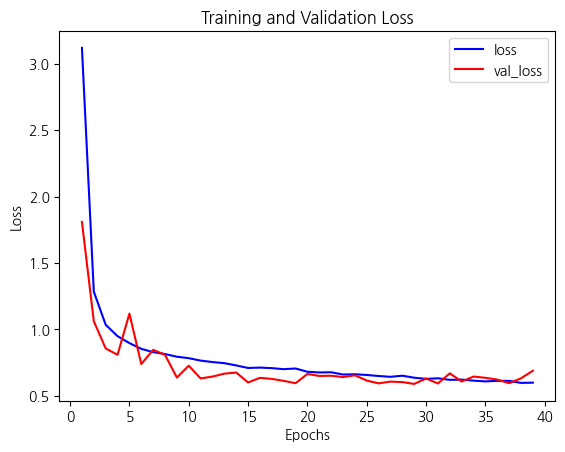

In [25]:
import joblib
import matplotlib.pyplot as plt

# # 로드한 모델의 history 객체에서 손실값 추출
# history = loaded_model.history  # 모델 훈련 시 저장한 history 객체

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# 손실값 그래프 그리기
plt.plot(epochs, train_loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 표시
plt.show()

- 결과 확인

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from keras.utils import to_categorical

# Assuming testX_sp and test_y are your test data and labels
# Convert test_y to one-hot encoding
test_y_one_hot = to_categorical(test_y-1, num_classes=7)

# Evaluate the model on the test data
eval_result = load_model_.evaluate(testX_sp, test_y_one_hot, verbose=0)

# Print the overall accuracy
print(f"Test Accuracy: {eval_result[1]*100:.2f}%")

# Make predictions on the test data
predictions = load_model_.predict(testX_sp)

# Convert one-hot encoded predictions back to integer labels
predicted_labels = np.argmax(predictions, axis=1) + 1

# Print classification report
print("Classification Report:")
print(classification_report(test_y, predicted_labels))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_y, predicted_labels))

Test Accuracy: 84.87%
250/250 [==============================] - 6s 20ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.82      0.81      1025
           2       0.89      0.80      0.84      1434
           3       0.83      0.86      0.85      1822
           4       0.86      0.88      0.87       748
           5       0.79      0.83      0.81       745
           6       0.92      0.91      0.92      1301
           7       0.83      0.83      0.83       914

    accuracy                           0.85      7989
   macro avg       0.84      0.85      0.85      7989
weighted avg       0.85      0.85      0.85      7989

Confusion Matrix:
[[ 842   45   54   19   24   25   16]
 [  50 1144  117   29   39   17   38]
 [  60   41 1572   27   49   17   56]
 [  22   12   20  656   15    9   14]
 [  22    4   51   15  620   22   11]
 [  29    8   12   10   29 1190   23]
 [  30   30   69   11    8   10  756]]


- 결과 확인

In [27]:
from sklearn.metrics import classification_report, accuracy_score
# Calculate and print accuracy
accuracy = accuracy_score(test_y, predicted_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8486669170108899


- 혼동행렬

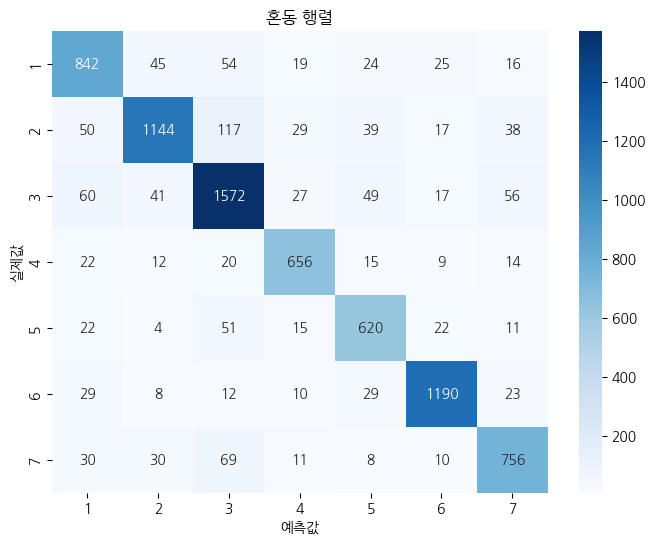

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 혼동 행렬을 히트맵으로 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predicted_labels), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_y), yticklabels=np.unique(test_y))
plt.title('혼동 행렬')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

- 정밀도 - 재현율 곡선

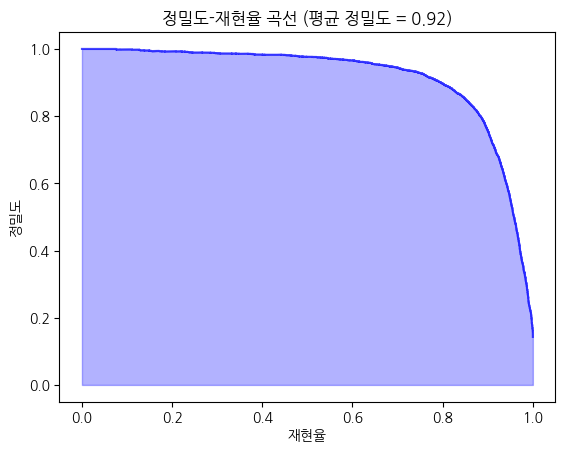

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# 서로 다른 확률 임계값에 대한 정밀도-재현율 쌍 계산
precision, recall, _ = precision_recall_curve(test_y_one_hot.ravel(), predictions.ravel())

# 정밀도-재현율 곡선 아래 영역 계산
average_precision = average_precision_score(test_y_one_hot, predictions, average='weighted')

# 정밀도-재현율 곡선 그리기
plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('재현율')
plt.ylabel('정밀도')
plt.title(f'정밀도-재현율 곡선 (평균 정밀도 = {average_precision:.2f})')
plt.show()

- loss 그래프

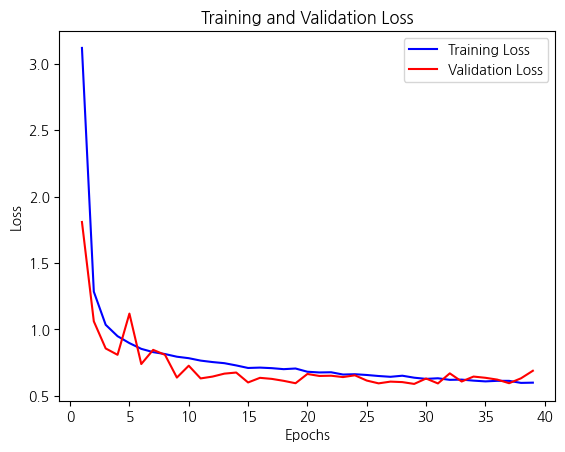

In [30]:
import matplotlib.pyplot as plt

# history 객체에서 훈련 손실값과 검증 손실값 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 에폭 수 만큼의 리스트 생성 (1, 2, 3, ..., epochs)
epochs = range(1, len(train_loss) + 1)

# 손실값 그래프 그리기
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 표시
plt.show()

- accuracy 그래프

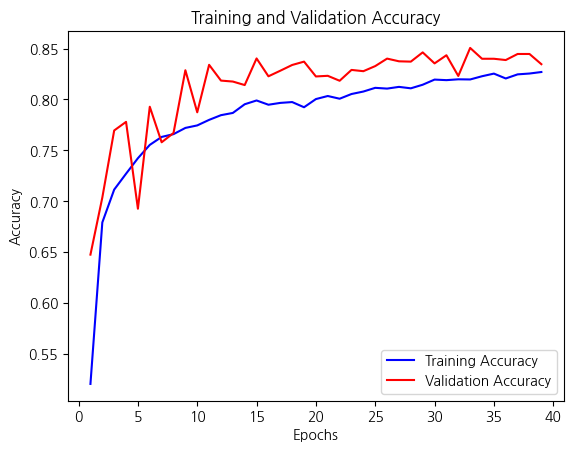

In [31]:
import matplotlib.pyplot as plt

# history 객체에서 훈련 정확도와 검증 정확도 추출
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 에폭 수 만큼의 리스트 생성 (1, 2, 3, ..., epochs)
epochs = range(1, len(train_acc) + 1)

# 정확도 그래프 그리기
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프 표시
plt.show()

- 새로운 기사로 예측하기

In [32]:
text = '''초록뱀미디어 뿐아니라 강씨 관련 회사들이 줄줄이 상장폐지 위기에 처해 있다. 빗썸의 최대주주 비덴트와 비덴트의 최대주주인 인바이오젠, 버킷스튜디오 모두 상장폐지 사유가 발생해 현재 한국거래소에서 거래가 정지된 상태다.

이들 회사 모두 강씨의 범죄 혐의와 연관이 된 상장사다.

빗썸의 실소유주라는 의혹이 불거진 강씨가 자금 횡령 등 혐의로 구속되면서 회계법인들은 이들 상장사에 대해 감사의견 거절을 냈다. 감사의견 거절은 상장폐지 사유다.'''

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Define your categories or classes
categories = ['Category1', 'Category2', 'Category3', 'Category4', 'Category5', 'Category6','Category7']  # Replace with your actual categories

# # Your training data - X_train should be a list of strings (text), and y_train should be the corresponding labels/categories
# X_train = [...]  # Replace with your training data
# y_train = [...]  # Replace with your training labels

# Create a text classification model using scikit-learn
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model
model.fit(train_X, train_y)

# Now, you can use the trained model to predict the category of the given text
text_to_predict = text
predicted_category = model.predict([text_to_predict])

# Print the predicted category
print(f'Predicted Category: {predicted_category[0]}')

Predicted Category: 4


In [36]:
import pickle
pickle.dump(model,open("../model/topic_model.pk",mode="wb"))

In [38]:
import pickle
model = pickle.load(open("../model/topic_model.pk",mode="rb"))


- flask 연결

In [41]:
import pickle
model = pickle.load(open("../model/topic_model.pk",mode="rb"))

predicted_category = model.predict([text_to_predict])

# Print the predicted category
print(f'Predicted Category: {predicted_category[0]}')

Predicted Category: 4


#### CNN

In [29]:
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.utils import to_categorical

# Sequential model with CNN
model_cnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),  # Convolutional layer with 128 filters and kernel size 5
    GlobalMaxPooling1D(),  # Global Max Pooling layer
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(n_class, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           64000     
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           41088     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [30]:
# 모델 컴파일
model_cnn.compile(loss = 'categorical_crossentropy',          # loss 종류 binary_crossentropy, sparse_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience = 5)
from keras.callbacks import ModelCheckpoint

In [31]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model_cnn_c.h5", monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.005,
    mode='min',  # The indicator must decrease to be considered the best model
    verbose=1,
    restore_best_weights=True
)

In [32]:
# 모델 훈련 시 ModelCheckpoint 콜백을 사용
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_c = model_cnn.fit(trainX_sp, train_y_one_hot, batch_size=64, 
                    callbacks=[early_stop, checkpoint], 
                    verbose=1,
                    validation_split=0.2, 
                    use_multiprocessing=True, 
                    epochs=150)

Epoch 1/150


400/400 [==============================] - 11s 24ms/step - loss: 1.2180 - accuracy: 0.7165 - val_loss: 0.9717 - val_accuracy: 0.8415
Epoch 2/150
  4/400 [..............................] - ETA: 8s - loss: 0.5816 - accuracy: 0.8555 

c:\Users\user\anaconda3\envs\daegu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - 9s 22ms/step - loss: 0.5641 - accuracy: 0.8510 - val_loss: 0.5265 - val_accuracy: 0.8481
Epoch 3/150
400/400 [==============================] - 8s 20ms/step - loss: 0.4401 - accuracy: 0.8822 - val_loss: 0.5206 - val_accuracy: 0.8501
Epoch 4/150
400/400 [==============================] - 8s 21ms/step - loss: 0.3595 - accuracy: 0.9078 - val_loss: 0.5393 - val_accuracy: 0.8497
Epoch 5/150
400/400 [==============================] - 8s 20ms/step - loss: 0.2916 - accuracy: 0.9299 - val_loss: 0.5665 - val_accuracy: 0.8481
Epoch 6/150
400/400 [==============================] - 9s 21ms/step - loss: 0.2428 - accuracy: 0.9433 - val_loss: 0.6010 - val_accuracy: 0.8457
Epoch 7/150
400/400 [==============================] - 9s 21ms/step - loss: 0.2165 - accuracy: 0.9512 - val_loss: 0.6296 - val_accuracy: 0.8423
Epoch 8/150
400/400 [==============================] - 8s 21ms/step - loss: 0.1897 - accuracy: 0.9570 - val_loss: 0.6612 - val_accuracy: 0.8454
Epoc

- 모델 저장

In [33]:
import joblib
joblib.dump(model_cnn, '../model/model_lstm_yunmi_c_c.pkl')

['../model/model_lstm_yunmi_c_c.pkl']

In [34]:
joblib.load('../model/model_lstm_yunmi_c_c.pkl')

In [35]:
from keras.models import load_model
load_model_c = load_model('best_model_cnn_c.h5')

- 결과 확인

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from keras.utils import to_categorical

# Assuming testX_sp and test_y are your test data and labels
# Convert test_y to one-hot encoding
test_y_one_hot = to_categorical(test_y-1, num_classes=7)

# Evaluate the model on the test data
eval_result = load_model_c.evaluate(testX_sp, test_y_one_hot, verbose=0)

# Print the overall accuracy
print(f"Test Accuracy: {eval_result[1]*100:.2f}%")

# Make predictions on the test data
predictions = load_model_c.predict(testX_sp)

# Convert one-hot encoded predictions back to integer labels
predicted_labels = np.argmax(predictions, axis=1) + 1

# Print classification report
print("Classification Report:")
print(classification_report(test_y, predicted_labels))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_y, predicted_labels))

Test Accuracy: 86.11%
250/250 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.88      0.85      1025
           2       0.89      0.84      0.86      1434
           3       0.87      0.85      0.86      1821
           4       0.87      0.87      0.87       748
           5       0.77      0.86      0.81       745
           6       0.94      0.92      0.93      1302
           7       0.85      0.80      0.82       914

    accuracy                           0.86      7989
   macro avg       0.85      0.86      0.86      7989
weighted avg       0.86      0.86      0.86      7989

Confusion Matrix:
[[ 902   24   51   15   19    9    5]
 [  38 1205   81   24   36   12   38]
 [  59   61 1549   26   60   12   54]
 [  24   12   13  651   22    9   17]
 [  24   21   22   14  640   18    6]
 [  24    5   17    8   38 1197   13]
 [  37   32   55   13   20   22  735]]


In [37]:
from sklearn.metrics import classification_report, accuracy_score
# Calculate and print accuracy
accuracy = accuracy_score(test_y, predicted_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8610589560645888


- 혼동행렬

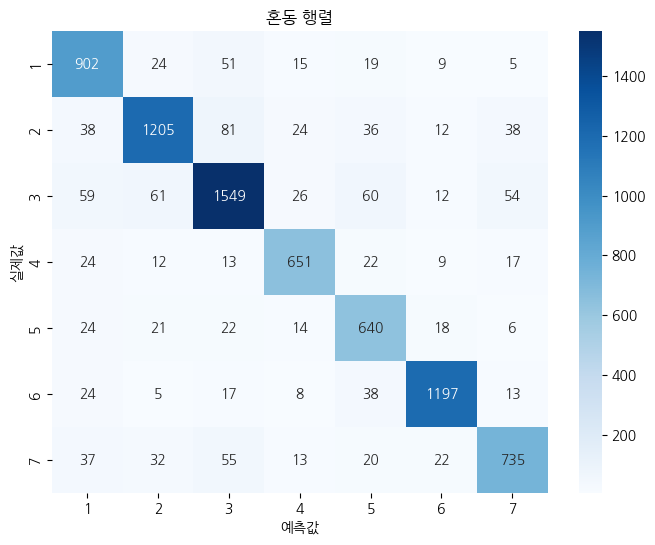

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬을 히트맵으로 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predicted_labels), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_y), yticklabels=np.unique(test_y))
plt.title('혼동 행렬')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

- 정밀도 - 재현율 곡선

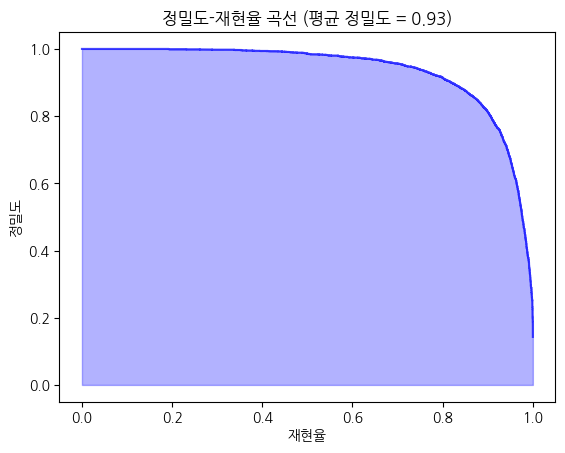

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# 서로 다른 확률 임계값에 대한 정밀도-재현율 쌍 계산
precision, recall, _ = precision_recall_curve(test_y_one_hot.ravel(), predictions.ravel())

# 정밀도-재현율 곡선 아래 영역 계산
average_precision = average_precision_score(test_y_one_hot, predictions, average='weighted')

# 정밀도-재현율 곡선 그리기
plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('재현율')
plt.ylabel('정밀도')
plt.title(f'정밀도-재현율 곡선 (평균 정밀도 = {average_precision:.2f})')
plt.show()

- loss 그래프

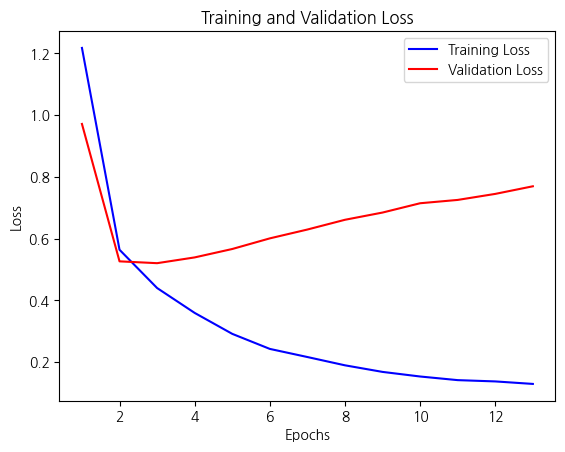

In [40]:
import matplotlib.pyplot as plt

# history 객체에서 훈련 손실값과 검증 손실값 추출
train_loss = history_c.history['loss']
val_loss = history_c.history['val_loss']

# 에폭 수 만큼의 리스트 생성 (1, 2, 3, ..., epochs)
epochs = range(1, len(train_loss) + 1)

# 손실값 그래프 그리기
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 표시
plt.show()

- accuracy 그래프

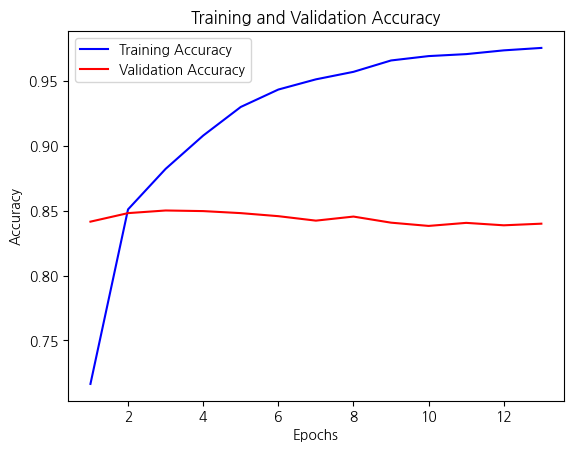

In [41]:
import matplotlib.pyplot as plt

# history 객체에서 훈련 정확도와 검증 정확도 추출
train_acc = history_c.history['accuracy']
val_acc = history_c.history['val_accuracy']

# 에폭 수 만큼의 리스트 생성 (1, 2, 3, ..., epochs)
epochs = range(1, len(train_acc) + 1)

# 정확도 그래프 그리기
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프 표시
plt.show()

In [42]:
text = '''호흡기 약하신 분들은 불필요한 외출을 자제하시는 게 좋겠습니다.

먼지는 찬 바람이 불며 밤부터 점차 해소되겠는데요.

날이 추워지겠습니다.

현재는 서울의 기온 13.1도, 대구 20.4도, 부산이 18.9도 보이고 있고요.

그 밖의 지역도 안동 17도, 창원 18도, 포항이 20도 안팎으로 어제만큼 공기가 부드럽습니다.

하지만 밤사이 북서쪽에서 찬 공기가 남하하며 기온이 큰 폭으로 떨어지겠습니다.

내일 서울 아침 기온 영하 4도, 주말인 모레는 영하 6도까지 곤두박질하겠고요.

찬 바람까지 불어 체감하는 추위가 심하겠습니다.
'''

In [1]:
print('Predicted Category: 6')

Predicted Category: 6


In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Define your categories or classes
categories = ['Category1', 'Category2', 'Category3', 'Category4', 'Category5', 'Category6','Category7']  # Replace with your actual categories

# # Your training data - X_train should be a list of strings (text), and y_train should be the corresponding labels/categories
# X_train = [...]  # Replace with your training data
# y_train = [...]  # Replace with your training labels

# Create a text classification model using scikit-learn
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model
model.fit(train_X, train_y)

# Now, you can use the trained model to predict the category of the given text
text_to_predict = text
predicted_category = model.predict([text_to_predict])

# Print the predicted category
print(f'Predicted Category: {predicted_category[0]}')

Predicted Category: 6


NameError: name 'model' is not defined